In [1]:
import os
import pandas as pd
import numpy as np
import sqlite3
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Configurações do Pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

c:\Users\Gustavo\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\Gustavo\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\Gustavo\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/f

In [2]:
# Conectar ao banco de dados SQLite
DB_FILE = "dados_acoes.db"
conn = sqlite3.connect(DB_FILE)

# Carregar as tabelas
# O usuário confirmou que as colunas 'date' já estão em formato datetime
try:
    df_diario = pd.read_sql_query("SELECT * FROM diario_com_indicadores", conn)
    df_semanal = pd.read_sql_query("SELECT * FROM semanal_com_indicadores", conn)
    df_mensal = pd.read_sql_query("SELECT * FROM mensal_com_indicadores", conn)
    


    # Verificação extra: garantir que o pandas as reconheceu como datetime
    # Se elas forem strings, o merge_asof falhará.
    df_diario['datetime'] = pd.to_datetime(df_diario['datetime'])
    df_semanal['datetime'] = pd.to_datetime(df_semanal['datetime'])
    df_mensal['datetime'] = pd.to_datetime(df_mensal['datetime'])

    print(f"Diário: {df_diario.shape}")
    print(f"Semanal: {df_semanal.shape}")
    print(f"Mensal: {df_mensal.shape}")
    
    print("\nTipo da coluna 'datetime' (Diário):", df_diario['datetime'].dtype)

except Exception as e:
    print(f"Erro ao carregar dados: {e}")
    print("Verifique se o nome do arquivo 'dados_acoes.db' e os nomes das tabelas estão corretos.")

finally:
    conn.close()

# Visualizar os dados
print("\nAmostra Dados Diários:")
print(df_diario.head())

Diário: (274555, 29)
Semanal: (57329, 29)
Mensal: (13087, 29)

Tipo da coluna 'datetime' (Diário): datetime64[ns]

Amostra Dados Diários:
    datetime     close      high       low      open       volume    ticker  EMA_9  SMA_21  SMA_50  SMA_200    RSI_14  MACD_12_26_9  MACDh_12_26_9  MACDs_12_26_9  BBL_20_2.0_2.0  BBM_20_2.0_2.0  BBU_20_2.0_2.0  BBB_20_2.0_2.0  BBP_20_2.0_2.0  STOCHk_14_3_3  STOCHd_14_3_3  STOCHh_14_3_3           OBV  ATRr_14  ADX_14  ADXR_14_2  DMP_14  DMN_14
0 2000-01-03  1.156394  1.156394  1.156394  1.156394  35389440000  PETR4.SA    NaN     NaN     NaN      NaN       NaN           NaN            NaN            NaN             NaN             NaN             NaN             NaN             NaN            NaN            NaN            NaN           NaN      NaN     NaN        NaN     NaN     NaN
1 2000-01-04  1.092423  1.092423  1.092423  1.092423  28861440000  PETR4.SA    NaN     NaN     NaN      NaN  0.000000           NaN            NaN            NaN           

In [3]:
# Garantir que tudo está ordenado por data para o merge_asof funcionar
df_diario = df_diario.sort_values(by='datetime')
df_semanal = df_semanal.sort_values(by='datetime')
df_mensal = df_mensal.sort_values(by='datetime')

# Renomear colunas de indicadores para evitar conflitos (ex: 'RSI' diário, 'RSI' semanal)
df_semanal = df_semanal.add_suffix('_sem')
df_mensal = df_mensal.add_suffix('_men')

# Renomear colunas de junção
df_semanal = df_semanal.rename(columns={'datetime_sem': 'datetime', 'ticker_sem': 'ticker'})
df_mensal = df_mensal.rename(columns={'datetime_men': 'datetime', 'ticker_men': 'ticker'})

# ---------------------------------------------------------------------------------
# Junção (Merge)
# ---------------------------------------------------------------------------------
# 1. Juntar Diário com Semanal
# Para cada 'ticker', vamos juntar a data diária com a data semanal mais próxima (anterior ou igual)
df_merged = pd.merge_asof(
    df_diario,
    df_semanal,
    on='datetime',
    by='ticker',
    direction='backward' # 'backward' pega o último dado semanal disponível para aquele dia
)

# 2. Juntar o resultado com o Mensal
df_merged = pd.merge_asof(
    df_merged,
    df_mensal,
    on='datetime',
    by='ticker',
    direction='backward'
)

print("\nAmostra de Dados Unificados:")
print(df_merged.head())

print(f"\nShape após merge: {df_merged.shape}")



Amostra de Dados Unificados:
    datetime       close        high         low        open       volume    ticker      EMA_9     SMA_21     SMA_50    SMA_200     RSI_14  MACD_12_26_9  MACDh_12_26_9  MACDs_12_26_9  BBL_20_2.0_2.0  BBM_20_2.0_2.0  BBU_20_2.0_2.0  BBB_20_2.0_2.0  BBP_20_2.0_2.0  STOCHk_14_3_3  STOCHd_14_3_3  STOCHh_14_3_3           OBV   ATRr_14     ADX_14  ADXR_14_2     DMP_14     DMN_14   close_sem    high_sem     low_sem    open_sem    volume_sem  EMA_9_sem  SMA_21_sem  SMA_50_sem  SMA_200_sem  RSI_14_sem  MACD_12_26_9_sem  MACDh_12_26_9_sem  MACDs_12_26_9_sem  BBL_20_2.0_2.0_sem  BBM_20_2.0_2.0_sem  BBU_20_2.0_2.0_sem  BBB_20_2.0_2.0_sem  BBP_20_2.0_2.0_sem  STOCHk_14_3_3_sem  STOCHd_14_3_3_sem  STOCHh_14_3_3_sem       OBV_sem  ATRr_14_sem  ADX_14_sem  ADXR_14_2_sem  DMP_14_sem  DMN_14_sem   close_men    high_men     low_men    open_men    volume_men  EMA_9_men  SMA_21_men  SMA_50_men  SMA_200_men  RSI_14_men  MACD_12_26_9_men  MACDh_12_26_9_men  MACDs_12_26_9_men  BB

In [4]:
# --- Definição do Alvo (y) ---
# Queremos prever o retorno futuro. Ex: retorno em 5 dias.
# (Preço em D+5 / Preço em D) - 1
PERIOD_HORIZON = 20

TIME_STEPS = 30 # Hiperparâmetro: quantos dias o LSTM vai "olhar para trás"

MODEL_FILE = "lstm_stock_model_20d_ts30.keras" # Nome do arquivo para salvar/carregar

In [5]:
# Agrupar por ticker para calcular o shift corretamente
df_merged['close_future'] = df_merged.groupby('ticker')['close'].shift(-PERIOD_HORIZON)

# Calcular o retorno futuro
df_merged['y_target'] = (df_merged['close_future'] / df_merged['close']) - 1

# --- Limpeza ---
# Remover dados onde não pudemos calcular o alvo (os últimos 5 dias de cada ticker)
# Também remover quaisquer NaNs gerados pelos merges ou cálculos de indicadores
df_final = df_merged.dropna()

if df_final.empty:
    print("ERRO: O DataFrame final está vazio após o dropna().")
    print("Verifique seus dados de entrada, a lógica de merge e o cálculo do 'y_target'.")
else:
    print(f"\nShape final após limpeza e 'y_target': {df_final.shape}")

    # --- Definição das Features (X) ---
    # Vamos assumir que as colunas de 'features' são todas menos as de identificação e o alvo
    # (Exclua 'date', 'ticker', 'open', 'high', 'low', 'close', 'volume' e colunas alvo)
    
    # Identifique suas colunas de indicadores aqui
    # Exemplo:
    features_diarias = [col for col in df_final.columns if col not in ['datetime', 'ticker'] and not col.endswith('_sem') and not col.endswith('_men')]
    features_semanais = [col for col in df_final.columns if col.endswith('_sem') and col not in ['date_sem', 'ticker_sem']]
    features_mensais = [col for col in df_final.columns if col.endswith('_men') and col not in ['date_men', 'ticker_men']]
    all_features = features_diarias + features_semanais + features_mensais
    
    # Defina as colunas que NUNCA devem ser features
    colunas_a_excluir = ['datetime', 'ticker', 'close_future', 'y_target']
    # Filtra para garantir que são numéricas E não são as colunas de exclusão
    features_numericas = [col for col in all_features if pd.api.types.is_numeric_dtype(df_final[col])]
    features = [col for col in features_numericas if col not in colunas_a_excluir]
    print(f"\nUsando {len(features)} features:")
    print(features)

    X = df_final[features]
    y = df_final['y_target']


Shape final após limpeza e 'y_target': (247527, 85)

Usando 81 features:
['close', 'high', 'low', 'open', 'volume', 'EMA_9', 'SMA_21', 'SMA_50', 'SMA_200', 'RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'BBL_20_2.0_2.0', 'BBM_20_2.0_2.0', 'BBU_20_2.0_2.0', 'BBB_20_2.0_2.0', 'BBP_20_2.0_2.0', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'STOCHh_14_3_3', 'OBV', 'ATRr_14', 'ADX_14', 'ADXR_14_2', 'DMP_14', 'DMN_14', 'close_sem', 'high_sem', 'low_sem', 'open_sem', 'volume_sem', 'EMA_9_sem', 'SMA_21_sem', 'SMA_50_sem', 'SMA_200_sem', 'RSI_14_sem', 'MACD_12_26_9_sem', 'MACDh_12_26_9_sem', 'MACDs_12_26_9_sem', 'BBL_20_2.0_2.0_sem', 'BBM_20_2.0_2.0_sem', 'BBU_20_2.0_2.0_sem', 'BBB_20_2.0_2.0_sem', 'BBP_20_2.0_2.0_sem', 'STOCHk_14_3_3_sem', 'STOCHd_14_3_3_sem', 'STOCHh_14_3_3_sem', 'OBV_sem', 'ATRr_14_sem', 'ADX_14_sem', 'ADXR_14_2_sem', 'DMP_14_sem', 'DMN_14_sem', 'close_men', 'high_men', 'low_men', 'open_men', 'volume_men', 'EMA_9_men', 'SMA_21_men', 'SMA_50_men', 'SMA_200_men', 'RSI_14_men

In [6]:
# --- Divisão Treino/Teste Temporal (antes do scaling) ---
# Faremos a divisão no df_final 2D

if not df_final.empty:
    split_index = int(len(df_final) * 0.8)
    
    # Dividir o DataFrame 2D principal
    df_train = df_final.iloc[:split_index]
    df_test = df_final.iloc[split_index:]
    
    # Separar X, y, e tickers para cada set
    X_train = df_train[features]
    y_train = df_train['y_target']
    ticker_train = df_train['ticker']
    
    X_test = df_test[features]
    y_test = df_test['y_target']
    ticker_test = df_test['ticker']
    
    print(f"Shape Treino 2D (X_train): {X_train.shape}")
    print(f"Shape Teste 2D (X_test): {X_test.shape}")
    print(f"Datas de Treino: {df_train['datetime'].min()} a {df_train['datetime'].max()}")
    print(f"Datas de Teste: {df_test['datetime'].min()} a {df_test['datetime'].max()}")
else:
    print("DataFrame vazio, pulando etapas.")

# ===================================================================
# ADICIONE ESTA NOVA CÉLULA (COMO [5.5] ou parte da [5])
# --- Normalização (Scaling) CORRETA ---

if 'X_train' in locals():
    # 1. Instanciar o Scaler
    scaler = StandardScaler()
    
    # 2. Fit (Ajustar) o scaler APENAS nos dados de TREINO
    scaler.fit(X_train)
    
    # 3. Transformar (Aplicar) em ambos os sets
    X_train_scaled_array = scaler.transform(X_train)
    X_test_scaled_array = scaler.transform(X_test)
    
    # 4. Criar DataFrames com os dados escalados (para a função de sequência)
    # Isso preserva os índices e nomes de colunas necessários para create_sequences_por_ticker
    X_train_scaled = pd.DataFrame(X_train_scaled_array, columns=features, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled_array, columns=features, index=X_test.index)
    
    print(f"\nX_train_scaled shape: {X_train_scaled.shape}")
    print(f"X_test_scaled shape: {X_test_scaled.shape}")
else:
    print("X_train não definido. Rode a célula anterior.")

Shape Treino 2D (X_train): (198021, 81)
Shape Teste 2D (X_test): (49506, 81)
Datas de Treino: 2000-01-03 00:00:00 a 2022-07-14 00:00:00
Datas de Teste: 2022-07-14 00:00:00 a 2025-09-25 00:00:00

X_train_scaled shape: (198021, 81)
X_test_scaled shape: (49506, 81)


In [7]:
def create_sequences_por_ticker(X_data, y_data, tickers, time_steps):
    """
    Cria sequências de dados 3D (para LSTM) agrupadas por ticker.
    Garante que as sequências não cruzem tickers diferentes.
    """
    all_X_seq, all_y_seq, all_indices = [], [], []
    
    # Usamos os índices originais de df_final para rastrear datas/tickers
    unique_tickers = tickers.unique()
    
    for i, ticker in enumerate(unique_tickers):
        # Filtrar dados para este ticker específico
        ticker_mask = (tickers == ticker)
        X_ticker = X_data[ticker_mask]
        y_ticker = y_data[ticker_mask]
        
        # O índice original é mantido
        ticker_indices = y_ticker.index
        
        # print(f"Processando Ticker: {ticker} ({i+1}/{len(unique_tickers)}) - {len(X_ticker)} amostras") # Debug
        
        # Aplicar a janela deslizante (sliding window) apenas neste ticker
        # Se o ticker tem menos dados que 'time_steps', ele será ignorado
        for j in range(len(X_ticker) - time_steps):
            # Sequência de features (ex: dias 0 a 29)
            seq = X_ticker.iloc[j:(j + time_steps)].values
            
            # Alvo (ex: dia 30)
            target = y_ticker.iloc[j + time_steps]
            
            # Índice do alvo (para rastrear data/ticker depois)
            target_index = ticker_indices[j + time_steps]
            
            all_X_seq.append(seq)
            all_y_seq.append(target)
            all_indices.append(target_index)
            
    return np.array(all_X_seq), np.array(all_y_seq), np.array(all_indices)

# --- Criar as Sequências (AGORA SEPARADAMENTE) ---
if 'X_train_scaled' in locals():
    
    print("Criando sequências de TREINO...")
    X_train_seq, y_train_seq, seq_indices_train = create_sequences_por_ticker(
        X_train_scaled, 
        y_train, 
        ticker_train, 
        TIME_STEPS
    )
    
    print("Criando sequências de TESTE...")
    X_test_seq, y_test_seq, seq_indices_test = create_sequences_por_ticker(
        X_test_scaled, 
        y_test, 
        ticker_test, 
        TIME_STEPS
    )
    
    # Esta é a variável que a Célula [9] (Avaliação) usa
    indices_test = seq_indices_test
    
    print(f"\nFormato das Sequências de Treino (X): {X_train_seq.shape}")
    print(f"Formato dos Alvos de Treino (y): {y_train_seq.shape}")
    
    print(f"\nFormato das Sequências de Teste (X): {X_test_seq.shape}")
    print(f"Formato dos Alvos de Teste (y): {y_test_seq.shape}")
else:
    print("Dados de treino/teste não encontrados. Rode as células anteriores.")

Criando sequências de TREINO...
Criando sequências de TESTE...

Formato das Sequências de Treino (X): (196131, 30, 81)
Formato dos Alvos de Treino (y): (196131,)

Formato das Sequências de Teste (X): (47586, 30, 81)
Formato dos Alvos de Teste (y): (47586,)


Nenhum modelo salvo encontrado em 'lstm_stock_model_20d_ts30.keras'. Iniciando novo treinamento...


Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 100)        │        72,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 158,301 (618.36 KB)

 Trainable params: 158,301 (618.36 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
2452/2452 ━━━━━━━━━━━━━━━━━━━━ 61s 24ms/step - loss: 0.0629 - mae: 0.0846 - val_loss: 0.0237 - val_mae: 0.0977
Epoch 2/100
2452/2452 ━━━━━━━━━━━━━━━━━━━━ 60s 24ms/step - loss: 0.0579 - mae: 0.0785 - val_loss: 0.0171 - val_mae: 0.0896
Epoch 3/100
2452/2452 ━━━━━━━━━━━━━━━━━━━━ 62s 25ms/step - loss: 0.0582 - mae: 0.0765 - val_loss: 0.0174 - val_mae: 0.0903
Epoch 4/100
2452/2452 ━━━━━━━━━━━━━━━━━━━━ 57s 23ms/step - loss: 0.0518 - mae: 0.0753 - val_loss: 0.0177 - val_mae: 0.0907
Epoch 5/100
2452/2452 ━━━━━━━━━━━━━━━━━━━━ 58s 24ms/step - loss: 0.0571 - mae: 0.0744 - val_loss: 0.0186 - val_mae: 0.0926
Epoch 6/100
2452/2452 ━━━━━━━━━━━━━━━━━━━━ 56s 23ms/step - loss: 0.0553 - mae: 0.0742 - val_loss: 0.0182 - val_mae: 0.0927
Epoch 7/100
2452/2452 ━━━━━━━━━━━━━━━━━━━━ 56s 23ms/step - loss: 0.0318 - mae: 0.0705 - val_loss: 0.0174 - val_mae: 0.0905
Epoch 8/100
2452/2452 ━━━━━━━━━━━━━━━━━━━━ 56s 23ms/step - loss: 0.0539 - mae: 0.0724 - val_loss: 0.0258 - val_mae: 0.0960
Epoch 9/100
2452

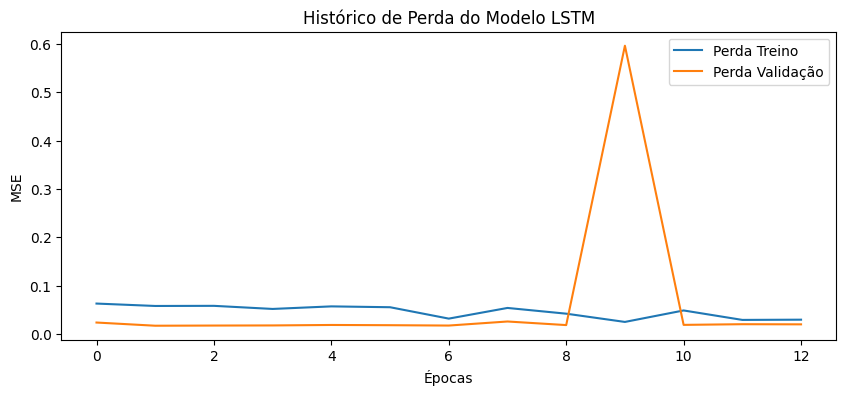

Treinamento concluído. Salvando modelo em 'lstm_stock_model_20d_ts30.keras'...
Modelo salvo com sucesso.


In [8]:
if 'X_train_seq' in locals():
    # 1. VERIFICAR SE O MODELO JÁ EXISTE
    if os.path.exists(MODEL_FILE):
        print(f"Encontrado modelo salvo! Carregando de '{MODEL_FILE}'...")
        model_lstm = load_model(MODEL_FILE)
        print("Modelo carregado com sucesso.")
        model_lstm.summary()

    # 2. SE NÃO EXISTIR, TREINAR E SALVAR
    else:
        print(f"Nenhum modelo salvo encontrado em '{MODEL_FILE}'. Iniciando novo treinamento...")
        
        # Pegar as dimensões dos dados de treino
        n_samples, time_steps, n_features = X_train_seq.shape

        # --- DEFINIÇÃO DO MODELO (Seu código original) ---
        model_lstm = Sequential(name="LSTM_Model")
        model_lstm.add(Input(shape=(time_steps, n_features)))
        model_lstm.add(LSTM(100, return_sequences=True, activation='tanh'))
        model_lstm.add(Dropout(0.2))
        model_lstm.add(LSTM(100, return_sequences=False, activation='tanh'))
        model_lstm.add(Dropout(0.2))
        model_lstm.add(Dense(50, activation='relu'))
        model_lstm.add(Dense(1, activation='linear'))

        # --- COMPILAÇÃO (Seu código original) ---
        model_lstm.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
        model_lstm.summary()

        # --- TREINAMENTO (Seu código original) ---
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, start_from_epoch=2)
        history = model_lstm.fit(
            X_train_seq, y_train_seq,
            epochs=100,
            batch_size=64,
            validation_split=0.2, # Usa 20% do *novo* set de treino para validação
            callbacks=[early_stopping],
            verbose=1
        )
        
        # --- Plotar histórico (Seu código original) ---
        plt.figure(figsize=(10, 4))
        plt.plot(history.history['loss'], label='Perda Treino')
        plt.plot(history.history['val_loss'], label='Perda Validação')
        plt.title('Histórico de Perda do Modelo LSTM')
        plt.xlabel('Épocas')
        plt.ylabel('MSE')
        plt.legend()
        plt.show()

        # --- A LINHA PARA SALVAR O MODELO ---
        print(f"Treinamento concluído. Salvando modelo em '{MODEL_FILE}'...")
        model_lstm.save(MODEL_FILE)
        print("Modelo salvo com sucesso.")

else:
    print("AVISO: 'X_train_seq' não foi definido. Pulando treino/carregamento do modelo.")


In [11]:
if 'model_lstm' in locals():
    # 1. Fazer previsões no set de teste
    y_pred = model_lstm.predict(X_test_seq).flatten()

    # 2. Buscar as informações originais (data, ticker) usando os índices salvos
    test_info = df_final.loc[indices_test]

    # 3. Criar o DataFrame de resultados
    df_results = pd.DataFrame({
        'date': test_info['datetime'],
        'ticker': test_info['ticker'],
        'y_real': y_test_seq,  # Alvos reais do set de teste sequenciado
        'y_pred': y_pred        # Previsões do modelo
    })

    # 4. Avaliação de Métricas Padrão
    mse = np.mean((df_results['y_pred'] - df_results['y_real'])**2)
    print(f"\nMean Squared Error (MSE) no Teste: {mse:.6f}")

    # 5. Avaliação Financeira
    correlation = df_results[['y_real', 'y_pred']].corr().iloc[0, 1]
    print(f"Correlação (Pearson) entre Real e Previsto: {correlation:.4f}")

    df_results['acerto_direcao'] = np.sign(df_results['y_real']) == np.sign(df_results['y_pred'])
    acuracia_direcao = df_results['acerto_direcao'].mean()
    print(f"Acurácia de Direção (Sign): {acuracia_direcao * 100:.2f}%")

    print("\nAmostra dos Resultados (LSTM):")
    print(df_results.head())

1488/1488 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step

Mean Squared Error (MSE) no Teste: 0.016623
Correlação (Pearson) entre Real e Previsto: 0.3574
Acurácia de Direção (Sign): 63.56%

Amostra dos Resultados (LSTM):
             date    ticker    y_real    y_pred  acerto_direcao
224517 2022-08-25  VIVA3.SA  0.056831  0.022373            True
224595 2022-08-26  VIVA3.SA  0.024295  0.014448            True
224653 2022-08-29  VIVA3.SA  0.019074  0.012446            True
224754 2022-08-30  VIVA3.SA  0.034171  0.006986            True
224812 2022-08-31  VIVA3.SA  0.025641  0.005741            True


In [12]:
# --- SESSÃO DE PREVISÃO E RECOMENDAÇÃO ---
# Esta seção gera previsões para o futuro usando os dados mais recentes.
# Ela assume que 'model_lstm' (o modelo treinado) e 'scaler' (o normalizador)
# já existem e foram treinados.

print("\n" + "="*50)
print("INICIANDO GERAÇÃO DE RECOMENDAÇÕES FUTURAS")
print(f"Usando modelo treinado para prever {PERIOD_HORIZON} dias no futuro.")
print(f"Usando os últimos {TIME_STEPS} dias de dados como entrada.")
print("="*50)

if 'model_lstm' in locals() and 'scaler' in locals() and 'features' in locals():
    
    # 1. Preparar os dados mais recentes (do df_merged, antes do dropna)
    # Queremos todas as linhas que tenham os indicadores (features) completos.
    # O 'y_target' pode (e provavelmente será) NaN para essas linhas.
    df_predict_input = df_merged.dropna(subset=features)
    
    # 2. Aplicar o Scaler (o mesmo que foi treinado)
    # Usamos .transform() e não .fit_transform()
    X_predict_scaled_array = scaler.transform(df_predict_input[features])
    
    # Recriar o DataFrame com os dados escalados
    X_predict_scaled = pd.DataFrame(
        X_predict_scaled_array, 
        columns=features, 
        index=df_predict_input.index
    )
    
    # Adicionar de volta o ticker e a data para podermos agrupar
    X_predict_scaled['ticker'] = df_predict_input['ticker']
    X_predict_scaled['datetime'] = df_predict_input['datetime']

    # 3. Montar as sequências de entrada para a previsão
    prediction_sequences = []
    tickers_for_prediction = []
    last_dates = []
    
    unique_tickers = X_predict_scaled['ticker'].unique()
    
    for ticker in unique_tickers:
        # Pegar os dados do ticker e ordenar pela data
        ticker_data = X_predict_scaled[
            X_predict_scaled['ticker'] == ticker
        ].sort_values(by='datetime')
        
        # Verificar se temos dados suficientes para uma sequência
        if len(ticker_data) >= TIME_STEPS:
            # Pegar as últimas TIME_STEPS linhas
            last_sequence = ticker_data[features].iloc[-TIME_STEPS:].values
            
            # Adicionar à lista
            prediction_sequences.append(last_sequence)
            tickers_for_prediction.append(ticker)
            last_dates.append(ticker_data['datetime'].iloc[-1])
        else:
            print(f"Ticker {ticker} ignorado (dados insuficientes: {len(ticker_data)} < {TIME_STEPS})")

    # 4. Fazer as Previsões
    if len(prediction_sequences) > 0:
        # Converter a lista de sequências em um array 3D numpy
        X_to_predict = np.array(prediction_sequences)
        print(f"\nGerando previsões para {X_to_predict.shape[0]} tickers...")
        
        # Fazer a previsão
        future_predictions = model_lstm.predict(X_to_predict).flatten()
        
        # 5. Criar e Rankear o DataFrame de Recomendações
        df_recommendations = pd.DataFrame({
            'ticker': tickers_for_prediction,
            'last_data_date': last_dates,
            f'predicted_return_{PERIOD_HORIZON}d': future_predictions
        })
        
        # Ordenar pelos maiores retornos previstos
        df_recommendations = df_recommendations.sort_values(
            by=f'predicted_return_{PERIOD_HORIZON}d', 
            ascending=False
        )
        
        print("\n--- TOP 10 RECOMENDAÇÕES DE TICKERS ---")
        print(df_recommendations.head(10))
        
        print("\n--- PIORES 10 TICKERS (POTENCIAIS VENDAS) ---")
        print(df_recommendations.tail(10))
        
    else:
        print("Nenhuma sequência válida pôde ser criada para previsão.")
else:
    print("ERRO: 'model_lstm' ou 'scaler' não foram encontrados.")
    print("Certifique-se de que o modelo foi treinado com sucesso antes de rodar esta etapa.")


INICIANDO GERAÇÃO DE RECOMENDAÇÕES FUTURAS
Usando modelo treinado para prever 20 dias no futuro.
Usando os últimos 30 dias de dados como entrada.

Gerando previsões para 64 tickers...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

--- TOP 10 RECOMENDAÇÕES DE TICKERS ---
      ticker last_data_date  predicted_return_20d
59  ASAI3.SA     2025-10-23              0.096409
29  MBRF3.SA     2025-10-23              0.076874
53  AMBP3.SA     2025-10-23              0.068560
50  NEOE3.SA     2025-10-23              0.056080
54  HBSA3.SA     2025-10-23              0.055183
63  MOTV3.SA     2025-10-23              0.052258
62  AURE3.SA     2025-10-23              0.048140
41  COGN3.SA     2025-10-23              0.047536
6   BBDC3.SA     2025-10-23              0.045555
33  ENEV3.SA     2025-10-23              0.045493

--- PIORES 10 TICKERS (POTENCIAIS VENDAS) ---
       ticker last_data_date  predicted_return_20d
24   SUZB3.SA     2025-10-23             -0.012400
38   PRIO3.SA     2025-10-23         